In [1]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from math import pi, isinf
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.optimize import curve_fit
from scipy.integrate import quad

import matplotlib.cm as cm

In [2]:
%matplotlib inline

In [3]:
font = {'family': 'serif', 'size': 12}
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [4]:
cmap = plt.get_cmap("tab10")

# system info

In [5]:
T_list = [20, 30, 40]
kb_in_kcalmol = 1.987204259*10**-3
#kbT = (TT+273.15) * kb_in_kcalmol #kcal/mol

mu_dict={20:[-16.9081, 0.123442],
        30: [-16.1373, 0.133707],
        40: [-15.6782,  0.135644]}

#mu_absorption = mu_dict[CT] #kcal/mol
ref_v0 = 0.0001

In [6]:
avogadro = 6.0221408e+23
a3_to_L = 10e-27
inva3_to_molperL = 1e27/avogadro

In [7]:
inva3_to_molperL

1660.5390561442869

In [8]:
c_dict = {}

for TT in T_list:
    
    c_dict[TT] = {}

    # name N_para N_water V[A^3] V_error[A^3] c_para[1/A^3] c_para_error
    c_list = np.genfromtxt('./molarc-'+str(TT)+'C.dat', str)[:,:]
    
    for a in c_list:
        c_dict[TT][a[0]] = {'c': float(a[5]), 
                        'n_p': int(a[1]), 
                        'n_w': int(a[2])}

### define functions for the S0 method

In [9]:
from S0functions import *

# Read in the values of S(k) at different k

In [10]:
Sk={}

In [11]:
for s in T_list:
    Sk[s] = {}
    
    for nn in [n for n in c_dict[s].keys()]:
        print(nn)
        Sk[s][nn] = {}
        for ii in ['NN', 'NC','CC']:
            Sk[s][nn][ii] = np.loadtxt(nn+"/Sk-"+ii+"-real-avg.list", skiprows=0)[:,:]

box35-11-3x3x3-20C
box35-13-3x3x3-20C
box35-1-3x3x3-20C
box35-15-3x3x3-20C
box35-17-3x3x3-20C
box35-19-3x3x3-20C
box35-21-3x3x3-20C
box35-3-3x3x3-20C
box35-5-3x3x3-20C
box35-7-3x3x3-20C
box35-9-3x3x3-20C
box35-23-3x3x3-20C
box35-27-3x3x3-20C
box35-31-3x3x3-20C
box35-35-3x3x3-20C
box35-11-3x3x3-30C
box35-13-3x3x3-30C
box35-1-3x3x3-30C
box35-15-3x3x3-30C
box35-17-3x3x3-30C
box35-19-3x3x3-30C
box35-21-3x3x3-30C
box35-3-3x3x3-30C
box35-5-3x3x3-30C
box35-7-3x3x3-30C
box35-9-3x3x3-30C
box35-23-3x3x3-30C
box35-27-3x3x3-30C
box35-31-3x3x3-30C
box35-35-3x3x3-30C
box35-11-3x3x3-40C
box35-13-3x3x3-40C
box35-1-3x3x3-40C
box35-15-3x3x3-40C
box35-17-3x3x3-40C
box35-19-3x3x3-40C
box35-21-3x3x3-40C
box35-3-3x3x3-40C
box35-5-3x3x3-40C
box35-7-3x3x3-40C
box35-9-3x3x3-40C
box35-23-3x3x3-40C
box35-27-3x3x3-40C
box35-31-3x3x3-40C
box35-35-3x3x3-40C


In [12]:
S0_dict = {}

kcut = 0.0025

for s in T_list: 
    S0_dict[s] = {}
    
    for nn in [n for n in c_dict[s].keys()]:
        S0_dict[s][nn] = {}
        S0_dict[s][nn].update(c_dict[s][nn])
        
        try:

            for ii in ['NN', 'NC','CC']:


                Sk_cut = np.asarray([sk for sk in Sk[s][nn][ii][1:] if sk[0]**2.+sk[1]**2.+sk[2]**2. < kcut
                                     and not np.isnan(sk[5])])
                #print(Sk_cut)
                ksqr_now = [ sk[0]**2.+sk[1]**2.+sk[2]**2. for sk in Sk_cut]
                sk_now = Sk_cut[:,3] 
                sk_error_now = Sk_cut[:,5]

                #if np.isnan(Sk[ii][nn][2,3]): continue
                popt, pcov = curve_fit(fit_OrnsteinZernike, 
                                   ksqr_now, 
                                   sk_now, )
                                   #sigma=sk_error_now,
                                   #absolute_sigma=False) #,
                                   # bounds=((-np.inf,  0), (np.inf, np.inf)))
                perr = np.sqrt(np.diag(pcov))
                #print(ii, nn,popt,perr)
                if isinf(perr[0]): popt = [float('nan'), float('nan')]
                #print(ii, frac,popt,perr)

                S0_dict[s][nn][ii]={'S0': popt[0], 
                                    'S0_error': perr[0],
                                    'value': popt, 
                                    'error': perr}
        except:
            print(s, nn, ii)
            del S0_dict[s][nn]
            

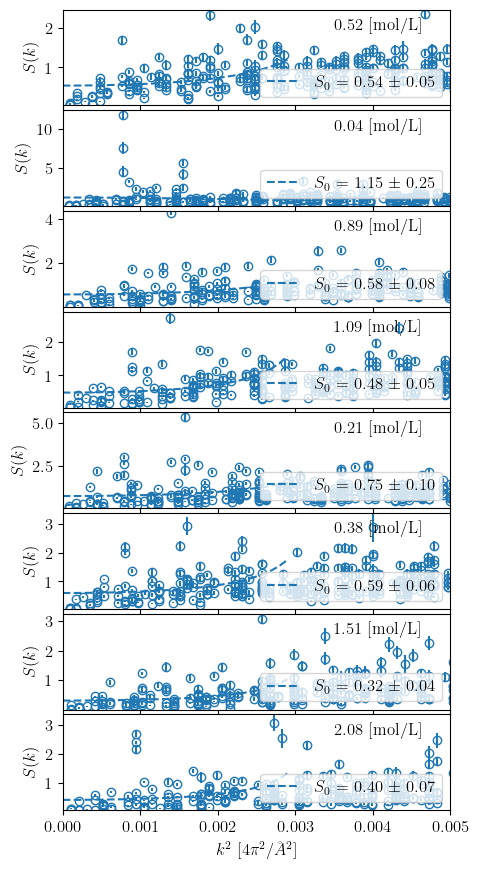

In [13]:
fig, ax = plt.subplots(8,1, sharex=True, sharey=False,figsize=(5,6.5*1.6))

krange = 0.0001*np.arange(30)

s = 20
ii = 'NN'

for i,nn in enumerate([n for n in c_dict[s].keys()][::2][:8]):
    
    sk_now = Sk[s][nn][ii][1:]
    
    ksqr_now = [ sk[0]**2.+sk[1]**2.+sk[2]**2. for sk in sk_now]
    sk_v_now = sk_now[:,3]
    sk_error_now = sk_now[:,5]
    popt = S0_dict[s][nn][ii]['value']
    perr = S0_dict[s][nn][ii]['error']
    c_now = S0_dict[s][nn]['c']
    
    ax[i].errorbar(ksqr_now, sk_v_now, sk_error_now,
             ls='',marker='o', c=cmap(0),
                   markerfacecolor='None')
    ax[i].plot(krange, fit_OrnsteinZernike(krange, *popt), '--',  c=cmap(0),
         label='$S_0~$=%5.2f $\pm$ %5.2f' % (popt[0],perr[0]))
    
    ax[i].text(0.7, 0.75, '%5.2f [mol/L]' % (c_now*inva3_to_molperL),
                 fontsize=12, transform=ax[i].transAxes,
                      verticalalignment='bottom')
    ax[i].legend(loc='lower right')
    ax[i].set_xlim([0,0.005])
    #ax[i].set_ylim([0.6,1.5])
    ax[i].margins(-0.0, x=None, y=None, tight=True)
    ax[i].set_ylabel(r"$S(k)$")
    
ax[-1].set_xlabel("$k^2$ [$4\pi^2$/$\AA^2$]")    
#ax[0].set_ylabel("$\lambda$")
fig.subplots_adjust(hspace=0.05, wspace=0.02)
#fig.tight_layout()

#fig.savefig("selected-k-S-mof5-co2.pdf", dpi=300, bbox_inches='tight')

Text(0.5, 0, '$c~[1/\\AA^3]$')

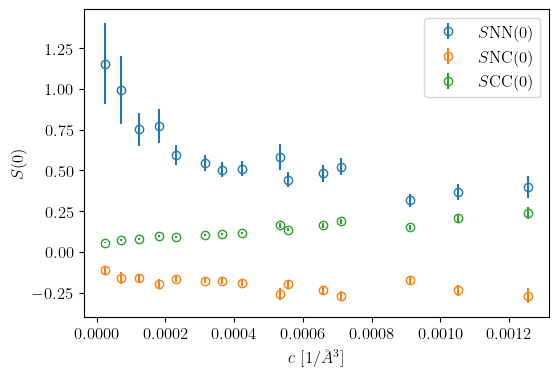

In [14]:
fig, ax = plt.subplots(figsize=(6,4))

for i,ii in enumerate(['NN', 'NC','CC']):
    slist_now = np.array([[ v['c'],v[ii]['S0'],v[ii]['S0_error']] for v in S0_dict[s].values()])
    ax.errorbar(slist_now[:,0],slist_now[:,1], slist_now[:,2],
           ls='',marker='o',markerfacecolor='None', c=cmap(i),
           label="$S$"+ii+"(0)")

ax.legend()
ax.set_ylabel("$S(0)$")
    
ax.set_xlabel("$c~[1/\AA^3]$")  

#fig.savefig("S-ca-"+sysname+".pdf", dpi=300, bbox_inches='tight')

In [15]:
S0_dict[s]

{'box35-11-3x3x3-20C': {'c': 0.000315496,
  'n_p': 297,
  'n_w': 9234,
  'NN': {'S0': 0.5448122220383719,
   'S0_error': 0.048682044950962705,
   'value': array([ 5.44812222e-01, -6.48929680e+04]),
   'error': array([4.86820450e-02, 1.42445655e+04])},
  'NC': {'S0': -0.1754448407681821,
   'S0_error': 0.016834645858026277,
   'value': array([-1.75444841e-01, -6.05177001e+04]),
   'error': array([1.68346459e-02, 1.61333577e+04])},
  'CC': {'S0': 0.1045609854471529,
   'S0_error': 0.006198882314931151,
   'value': array([ 1.04560985e-01, -5.52916430e+04]),
   'error': array([6.19888231e-03, 1.05932480e+04])}},
 'box35-13-3x3x3-20C': {'c': 0.000363702,
  'n_p': 351,
  'n_w': 9369,
  'NN': {'S0': 0.5051846254337207,
   'S0_error': 0.044056950769896505,
   'value': array([ 5.05184625e-01, -7.87354043e+04]),
   'error': array([4.40569508e-02, 1.21439209e+04])},
  'NC': {'S0': -0.17790812377864193,
   'S0_error': 0.01693932337878289,
   'value': array([-1.77908124e-01, -7.24328309e+04]),
   '

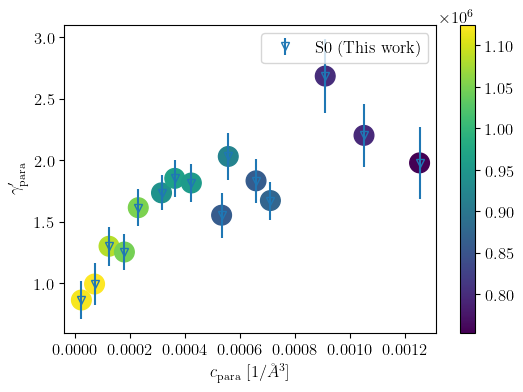

In [17]:
fig, ax = plt.subplots(figsize=(6,4))


# $0:ca $1:c_ratio $2:SAA $3:SAA_error $4:SAB $5:SAB_error
slist_now = np.array([[ v['c'], v['n_p']/v['n_w'], \
                       v['NN']['S0'],v['NN']['S0_error'], \
                       v['NC']['S0'],v['NC']['S0_error'],
                      v['n_p']/v['c']] \
                      for v in S0_dict[s].values()])

ac = ax.scatter(slist_now[:,0], get_activity_coefficient(slist_now[:,2], slist_now[:,4], slist_now[:,1]),
          c=slist_now[:,6],s=200)

plt.colorbar(ac)
ax.errorbar(slist_now[:,0],
        get_activity_coefficient(slist_now[:,2], slist_now[:,4], slist_now[:,1]),
            np.abs(get_activity_coefficient(slist_now[:,2]+slist_now[:,3], slist_now[:,4]-slist_now[:,5], slist_now[:,1])
            -get_activity_coefficient(slist_now[:,2], slist_now[:,4], slist_now[:,1])),
            ls='',
            marker='v',markerfacecolor='None',
           label='S0 (This work)')


ax.set_ylabel("$\gamma'_\mathrm{para}$")
    
ax.set_xlabel('$c_\mathrm{para}~[1/\AA^3]$')  
#ax.set_xticks(np.arange(2, 8.1, step=2))
ax.legend()

#fig.savefig("dilute-gamma-ca-"+sysname+".pdf", dpi=300, bbox_inches='tight')

/Users/tc/IST-Cheng Dropbox/Bingqing Cheng/solubility/para-EtOH/md-charmm/S0functions.py:33: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  mu_now = kbT*quad(int_func, np.log(c0), a)[0]
/Users/tc/IST-Cheng Dropbox/Bingqing Cheng/solubility/para-EtOH/md-charmm/S0functions.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  mu_error_now = kbT*quad(int_error_func, np.log(c0), a)[0]/(n_sample-1)**0.5
/Users/tc/IST-Cheng Dropbox/Bingqing Cheng/solubility/para-EtOH/m

Text(0.5, 0, '$c_\\mathrm{urea}$ [mol/L]')

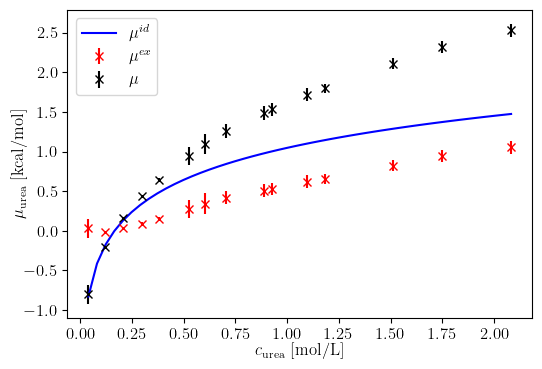

In [19]:
# compute mu^ex_ion using Gibbs-Duhem
kbT = (float(s)+273.15) * kb_in_kcalmol

ca_now = np.array([ v['c'] for v in S0_dict[s].values()])

xa_now = np.array([ v['n_p']/(v['n_p']+v['n_w']) for v in S0_dict[s].values()])
xb_now = 1- xa_now

ca_ratio_now = np.array([ v['n_p']/v['n_w'] for v in S0_dict[s].values()])
cb_ratio_now = 1/ca_ratio_now

saa_now = np.array([ [v['NN']['S0'],v['NN']['S0_error']] for v in S0_dict[s].values()])
sab_now = np.array([ [v['NC']['S0'],v['NC']['S0_error']] for v in S0_dict[s].values()])
sbb_now = np.array([ [v['CC']['S0'],v['CC']['S0_error']] for v in S0_dict[s].values()])

fig, ax = plt.subplots(figsize=(6,4))
"""
mu_p = mu_x_GH(saa_now,sab_now,sbb_now,xa_now,0.1,kbT)
ax.errorbar(ca_now*inva3_to_molperL,
            mu_p[:,1]-ideal_mu(ca_now, ca_now[0], kbT),
            yerr=mu_p[:,2], 
            marker='x',markerfacecolor='None',ls='',
            c='k', label='$\mu^{ex}$ (GH)')

ax.errorbar(ca_now*inva3_to_molperL,
            mu_p[:,1],
            yerr=mu_p[:,2], 
            marker='o',markerfacecolor='None',ls='',
            c='k', label='$\mu$')
"""

mu_p = excess_mu(ca_now,saa_now,sab_now,ca_ratio_now,ref_v0,kbT)

ax.errorbar(ca_now*inva3_to_molperL,
            mu_p[:,1],
            yerr=np.abs(mu_p[:,2]), 
            marker='x',markerfacecolor='None',ls='',
            c='r', label='$\mu^{ex}$')

ax.errorbar(ca_now*inva3_to_molperL,
            mu_p[:,1] + ideal_mu(ca_now, 0.0001, kbT),
            yerr=np.abs(mu_p[:,2]), 
            marker='x',markerfacecolor='None',ls='',
            c='k', label='$\mu$')

ca_plotrange = np.linspace(np.amin(ca_now), np.amax(ca_now))
ax.plot(ca_plotrange*inva3_to_molperL, ideal_mu(ca_plotrange, ref_v0, kbT), 
        'blue',
        label='$\mu^{id}$')


ax.legend()

ax.set_ylabel("$\mu_\mathrm{urea}$ [kcal/mol]",labelpad=-2)  
ax.set_xlabel("$c_\mathrm{urea}$ [mol/L]",labelpad=0) 

In [20]:
for s in T_list:
    # compute mu^ex_ion using Gibbs-Duhem
    kbT = (float(s)+273.15) * kb_in_kcalmol

    ca_now = np.array([ v['c'] for v in S0_dict[s].values()])

    xa_now = np.array([ v['n_p']/(v['n_p']+v['n_w']) for v in S0_dict[s].values()])
    xb_now = 1- xa_now

    ca_ratio_now = np.array([ v['n_p']/v['n_w'] for v in S0_dict[s].values()])
    cb_ratio_now = 1/ca_ratio_now

    saa_now = np.array([ [v['NN']['S0'],v['NN']['S0_error']] for v in S0_dict[s].values()])
    sab_now = np.array([ [v['NC']['S0'],v['NC']['S0_error']] for v in S0_dict[s].values()])
    sbb_now = np.array([ [v['CC']['S0'],v['CC']['S0_error']] for v in S0_dict[s].values()])

    mu_ex = excess_mu(ca_now,saa_now,sab_now,ca_ratio_now,ref_v0,kbT)
    print(mu_ex[::5])

    np.savetxt('mu-ex-T-'+str(s)+'.dat', mu_ex)

/Users/tc/IST-Cheng Dropbox/Bingqing Cheng/solubility/para-EtOH/md-charmm/S0functions.py:33: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  mu_now = kbT*quad(int_func, np.log(c0), a)[0]
/Users/tc/IST-Cheng Dropbox/Bingqing Cheng/solubility/para-EtOH/md-charmm/S0functions.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  mu_error_now = kbT*quad(int_error_func, np.log(c0), a)[0]/(n_sample-1)**0.5
/Users/tc/IST-Cheng Dropbox/Bingqing Cheng/solubility/para-EtOH/m

[[3.15496000e-04 2.75536268e-01 1.16971360e-01]
 [5.58252000e-04 5.28346141e-01 7.88709388e-02]
 [2.30931000e-04 1.52851497e-01 2.75861082e-02]]
[[3.11900000e-04 3.06524715e-01 1.05994508e-01]
 [5.52061000e-04 5.22031046e-01 7.15736077e-02]
 [2.28250000e-04 1.85484677e-01 2.38587969e-02]]
[[3.08287000e-04 2.62471400e-01 8.55970451e-02]
 [5.45970000e-04 4.49095624e-01 5.93413141e-02]
 [2.25545000e-04 1.85872673e-01 2.01707260e-02]]


In [ ]:
dmu_fep_list = np.genfromtxt('../ti-box20-soft-l20-bar/dmu.dat',str)
dmu_fep = np.array([ [int(s[3]), float(s[4]), float(s[5])] for s in dmu_fep_list])

In [ ]:
sum_dmu_fep = 0 * dmu_fep

for i, dd in enumerate(dmu_fep):
    sum_dmu_fep[i, 0] = dd[0]/dmu_fep[-1,0]
    sum_dmu_fep[i, 1] = dd[1]
    sum_dmu_fep[i, 2] = dd[2]
    if i >= 1: 
        sum_dmu_fep[i, 1] += sum_dmu_fep[i-1, 1]
        sum_dmu_fep[i, 2] += sum_dmu_fep[i-1, 2]

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))

ax.errorbar(sum_dmu_fep[:,0], sum_dmu_fep[:,1], yerr=sum_dmu_fep[:,2]
        ,marker='o')

#ax.plot(l_mu[:,0], 0*l_mu[:,1],
#         c='k',lw=0.2, ls='-')

ax.set_xlabel("$\lambda$", labelpad=0) 
ax.set_ylabel("$\mu^{ab}$ [ kcal/mol ]", labelpad=0) 

ax.legend(loc='upper right',ncol=1,frameon=False,fontsize=10.5,handletextpad=0.1)

ax.text(0.5, 0.1, "20 C",
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

#fig.savefig("MOF5-co2-mu_ab-"+NN+"-218K.pdf", dpi=300, bbox_inches='tight')